In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# 数据加载
# 读取电影数据和类别信息
movies_df = pd.read_csv('../data/ml-25m/movies.csv')
embeddings = np.load('save/ml-25m-reweight/items_embeddings.npy')  # N x 64
movies_df['genres'] = movies_df['genres'].str.split('|')

# 获取类别信息
mlb = MultiLabelBinarizer()
genres_matrix = mlb.fit_transform(movies_df['genres'])  # N x C
genre_labels = mlb.classes_  # 类别名称
print(genre_labels)
num_genres = len(genre_labels)

# 数据处理
movie_embeddings = torch.tensor(embeddings, dtype=torch.float32)  # N x 64
genre_matrix = torch.tensor(genres_matrix, dtype=torch.float32)   # N x C

/SSD_DISK/users/yaoyuxuan/anaconda3/envs/GCN/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['(no genres listed)' 'Action' 'Adventure' 'Animation' 'Children' 'Comedy'
 'Crime' 'Documentary' 'Drama' 'Fantasy' 'Film-Noir' 'Horror' 'IMAX'
 'Musical' 'Mystery' 'Romance' 'Sci-Fi' 'Thriller' 'War' 'Western']


In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer


data = movies_df['genres']
# 将每部电影的类别列表转为原始格式（去掉空字符串）
data_cleaned = data.apply(lambda x: x if isinstance(x, list) else [])

# 用 CountVectorizer 构建稀疏矩阵，直接以单词级别处理
count_vectorizer = CountVectorizer(tokenizer=lambda x: x, lowercase=False)
count_matrix = count_vectorizer.fit_transform(data_cleaned)

# 使用 TfidfTransformer 计算 TF-IDF
tfidf_transformer = TfidfTransformer()
tfidf_matrix = tfidf_transformer.fit_transform(count_matrix)

# 提取类别标签和其对应的权重
feature_names = count_vectorizer.get_feature_names_out()
tfidf_scores = tfidf_matrix.sum(axis=0).A1  # 对每个标签在所有电影中的权重求和
category_weights = dict(zip(feature_names, tfidf_scores))

# 转换为 DataFrame 并展示
df_weights_fixed = pd.DataFrame(list(category_weights.items()), columns=["Category", "Weight"])

# 归一化权重并均衡化
df_weights_fixed['Weight'] = (
    (df_weights_fixed['Weight'] / df_weights_fixed['Weight'].sum()) ** 0.5
)
df_weights_fixed['Weight'] = df_weights_fixed['Weight'] / df_weights_fixed['Weight'].sum()
df_weights_fixed['Weight'] = df_weights_fixed['Weight'] ** 0.5
# 展示归一化后的权重
df_weights_fixed

,Category,Weight
0,(no genres listed),0.235112
1,Action,0.245095
2,Adventure,0.212880
3,Animation,0.209351
4,Children,0.202947
5,Comedy,0.308932
6,Crime,0.230818
7,Documentary,0.250877
8,Drama,0.334113
9,Fantasy,0.197564


In [13]:


# 超参数
embedding_dim = embeddings.shape[1]  # 64
batch_size = 128
num_epochs = 50
learning_rate = 0.001

# 定义 Dataset
class MovieDataset(Dataset):
    def __init__(self, embeddings, genre_matrix):
        self.embeddings = embeddings
        self.genre_matrix = genre_matrix

    def __len__(self):
        return self.embeddings.shape[0]

    def __getitem__(self, idx):
        return self.embeddings[idx], self.genre_matrix[idx]

# 加载数据
dataset = MovieDataset(movie_embeddings, genre_matrix)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# 定义模型
class GenreEmbeddingModel(nn.Module):
    def __init__(self, num_genres, embedding_dim, category_weights):
        super(GenreEmbeddingModel, self).__init__()
        # 类别嵌入矩阵
        self.genre_embeddings = nn.Parameter(torch.randn(num_genres, embedding_dim))
        # 类别权重，确保它是一个张量并移动到模型所用的设备上
        self.category_weights = nn.Parameter(torch.tensor(category_weights, dtype=torch.float32), requires_grad=False)

    def forward(self, genre_matrix):
        # 按类别权重对类别矩阵进行加权
        weighted_genre_matrix = genre_matrix * self.category_weights.unsqueeze(0)
        # 根据加权后的类别矩阵计算加权嵌入
        weighted_embeddings = torch.matmul(weighted_genre_matrix, self.genre_embeddings) / torch.sum(weighted_genre_matrix, dim=1, keepdim=True)
        return weighted_embeddings

# 初始化模型
model = GenreEmbeddingModel(num_genres=num_genres, embedding_dim=embedding_dim, category_weights=df_weights_fixed['Weight'].values)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for batch_embeddings, batch_genres in dataloader:
        optimizer.zero_grad()
        # 预测
        predicted_embeddings = model(batch_genres)
        # 计算损失
        loss = criterion(predicted_embeddings, batch_embeddings)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

# 保存类别嵌入
torch.save(model.genre_embeddings.data, 'genre_embeddings.pt')
print("训练完成，类别嵌入已保存为 genre_embeddings.pt")


Epoch [1/50], Loss: 220.3706
Epoch [2/50], Loss: 132.9228
Epoch [3/50], Loss: 84.0017
Epoch [4/50], Loss: 55.8405
Epoch [5/50], Loss: 39.4394
Epoch [6/50], Loss: 29.8498
Epoch [7/50], Loss: 24.2518
Epoch [8/50], Loss: 21.0078
Epoch [9/50], Loss: 19.1596
Epoch [10/50], Loss: 18.1321
Epoch [11/50], Loss: 17.5790
Epoch [12/50], Loss: 17.2928
Epoch [13/50], Loss: 17.1501
Epoch [14/50], Loss: 17.0803
Epoch [15/50], Loss: 17.0472
Epoch [16/50], Loss: 17.0298
Epoch [17/50], Loss: 17.0210
Epoch [18/50], Loss: 17.0152
Epoch [19/50], Loss: 17.0126
Epoch [20/50], Loss: 17.0087
Epoch [21/50], Loss: 17.0066
Epoch [22/50], Loss: 17.0052
Epoch [23/50], Loss: 17.0043
Epoch [24/50], Loss: 17.0024
Epoch [25/50], Loss: 17.0016
Epoch [26/50], Loss: 17.0009
Epoch [27/50], Loss: 16.9996
Epoch [28/50], Loss: 16.9999
Epoch [29/50], Loss: 17.0000
Epoch [30/50], Loss: 16.9996
Epoch [31/50], Loss: 16.9994
Epoch [32/50], Loss: 16.9986
Epoch [33/50], Loss: 16.9979
Epoch [34/50], Loss: 16.9981
Epoch [35/50], Loss: 

In [16]:
# 测试模型结果
def get_movie_embedding(genres, genre_embeddings, mlb, category_weights):
    """
    根据电影的类别信息，计算其平均 embedding。
    """
    # 将输入的 genres 转化为 one-hot 编码
    genre_vector = mlb.transform([genres])  # 1 x C
    genre_vector = torch.tensor(genre_vector, dtype=torch.float32)  # 转为 Tensor
    # 按类别权重对类别矩阵进行加权
    weighted_genre_vector = genre_vector * torch.tensor(category_weights, dtype=torch.float32)
    # 通过类别 embedding 计算加权平均电影 embedding
    movie_embedding = torch.matmul(weighted_genre_vector, genre_embeddings) / torch.sum(genre_vector)
    return movie_embedding.squeeze(0)  # 去掉额外维度

def get_top_k_similar_movies(movie_embedding, movie_embeddings, k=5):
    """
    计算给定电影 embedding 和已有电影 embedding 的相似程度，返回 top-k 索引。
    """
    # 计算余弦相似度
    similarity = torch.nn.functional.cosine_similarity(movie_embedding.unsqueeze(0), movie_embeddings)
    # 获取 top-k 索引
    top_k_indices = torch.topk(similarity, k=k).indices
    return top_k_indices, similarity[top_k_indices]


# 加载训练好的类别嵌入
loaded_genre_embeddings = torch.load('save/ml-25m-unweight/genre_embeddings.pt')


new_movie_genres = ['Drama', 'Comedy'] 
# new_movie_genres = ['Comedy'] 
# 1. 计算新电影的 embedding
new_movie_embedding = get_movie_embedding(new_movie_genres, loaded_genre_embeddings, mlb, category_weights=df_weights_fixed['Weight'].values )
# 2. 获取 top-k 相似电影索引
top_k_indices, similarities = get_top_k_similar_movies(new_movie_embedding, movie_embeddings, k=10)

# 输出结果
print(f"新电影类别: {new_movie_genres}")
print(f"Top-5 相似电影索引: {top_k_indices.tolist()}")
print(f"相似度: {similarities.tolist()}")

top_k_movies = movies_df.iloc[top_k_indices.tolist()]
print("\nTop-5 相似电影:")
print(top_k_movies[['title', 'genres']])

新电影类别: ['Drama', 'Comedy']
Top-5 相似电影索引: [36163, 1227, 277, 2154, 81, 10870, 24740, 254, 2024, 36484]
相似度: [0.4931318759918213, 0.48591578006744385, 0.4748347997665405, 0.4737667441368103, 0.46303069591522217, 0.4574896991252899, 0.45420166850090027, 0.4502018094062805, 0.4476514756679535, 0.4458251893520355]

Top-5 相似电影:
                                     title                   genres
36163  The Incredible Jessica James (2017)        [Comedy, Romance]
1227         Thieves (Voleurs, Les) (1996)  [Crime, Drama, Romance]
277                          Priest (1994)                  [Drama]
2154                       20 Dates (1998)        [Comedy, Romance]
81               Angels and Insects (1995)         [Drama, Romance]
10870                Rocket Science (2007)          [Comedy, Drama]
24740                 Les Héritiers (2014)          [Comedy, Drama]
254     Madness of King George, The (1994)          [Comedy, Drama]
2024                      Celebrity (1998)                 [Come

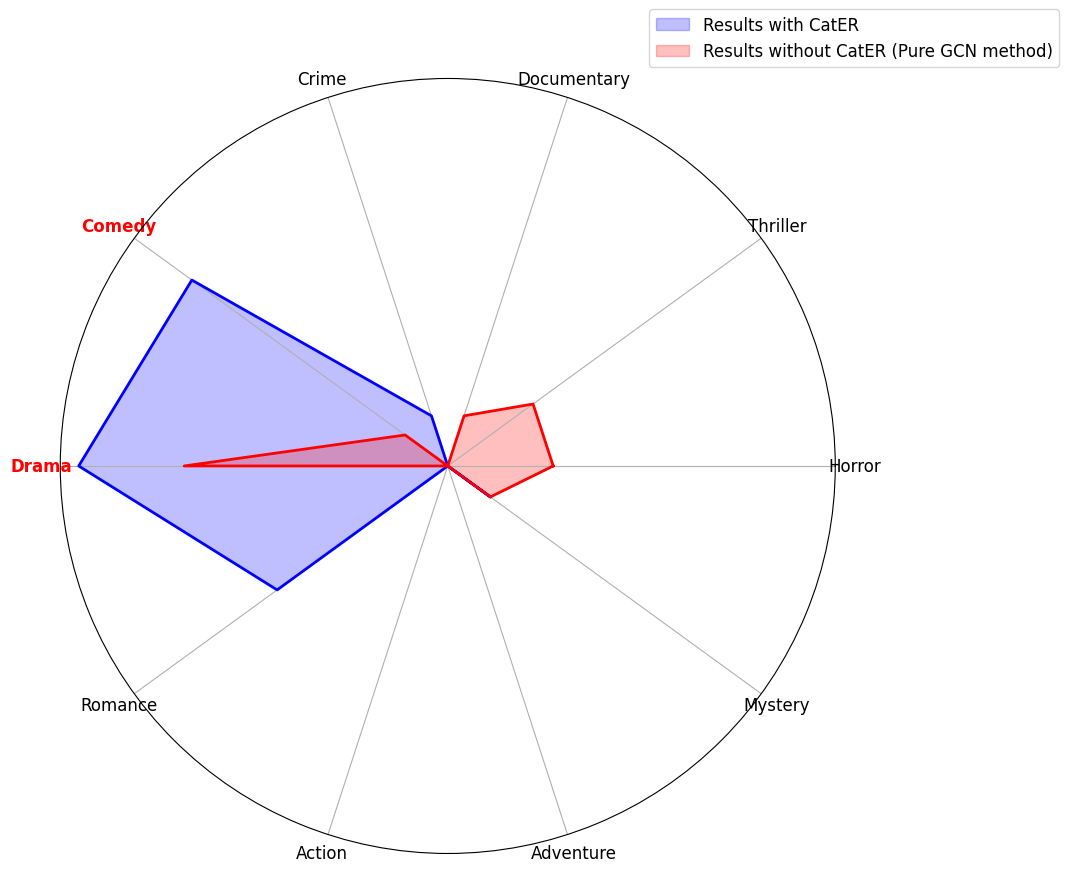

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Define category labels
categories = [
     'Horror','Thriller', 
    'Documentary','Crime',  'Comedy', 'Drama', 'Romance', 'Action', 'Adventure',
    'Mystery', 
]

# Data for A and B
data_A = [
    ['Comedy', 'Romance'],
    ['Crime', 'Drama', 'Romance'],
    ['Drama'],
    ['Comedy', 'Romance'],
    ['Drama', 'Romance'],
    ['Comedy', 'Drama'],
    ['Comedy', 'Drama'],
    ['Comedy', 'Drama'],
    ['Comedy'],
    ['Drama', 'Mystery']
]

data_B = [
    ['Thriller'],
    ['Horror'],
    ['Drama', 'War'],
    ['Horror'],
    ['Thriller'],
    ['Comedy', 'Drama', 'Mystery'],
    ['Drama'],
    ['Drama'],
    ['Drama'],
    ['Documentary']
]

# Count frequencies
counter_A = Counter([label for movie in data_A for label in movie])
counter_B = Counter([label for movie in data_B for label in movie])

freq_A = [counter_A[category] for category in categories]
freq_B = [counter_B[category] for category in categories]

# Prepare radar chart
num_vars = len(categories)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

freq_A += freq_A[:1]  # Close the circle for A
freq_B += freq_B[:1]  # Close the circle for B

# Plot radar chart
fig, ax = plt.subplots(figsize=(10, 14), subplot_kw=dict(polar=True))

ax.fill(angles, freq_A, color='blue', alpha=0.25, label='Results with CatER')
ax.plot(angles, freq_A, color='blue', linewidth=2)

ax.fill(angles, freq_B, color='red', alpha=0.25, label='Results without CatER (Pure GCN method)')
ax.plot(angles, freq_B, color='red', linewidth=2)

ax.set_yticks([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, fontsize=12)

# Highlight "Drama" and "Comedy" in red
for label, angle in zip(ax.get_xticklabels(), angles):
    if label.get_text() in ["Drama", "Comedy"]:
        label.set_color("red")
        label.set_weight("bold")

ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=12)

# plt.title('Comparison of Category Frequencies in A and B', fontsize=16, pad=20)
plt.show()
